# README
SVM and NN is tried on the Joint (mediapipe-produced) dataset. Only Base variant is tried. The models discussed in the paper are noted in the code.
Along with other models not in the paper, SVM (joint) expanded for both z coordinate and not z coordinate are attempted in this file.



![](https://mediapipe.dev/images/mobile/hand_landmarks.png)

# Load data

## Standard

In [1]:
!pip install datasets -q

from datasets import load_dataset

In [ ]:
#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os

from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import time
from tqdm import tqdm
import seaborn as sns
import pandas as pd

In [ ]:
# Stringify a numeric label into textual form
def decode_label(label):
    if label == 1:
        return "rock"
    elif label == 0:
        return "paper"
    elif label == 2:
        return "scissors"
    elif label == 3:
        return "none"
    return None
    # return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image


In [ ]:
#Utility from Henry
from scipy.spatial.distance import euclidean
import numpy as np
import re
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def parse_landmarks(landmarks_str):
    matches = re.findall(r'landmark \{\s*x: ([e\d.-]+)\s*y: ([e\d.-]+)\s*z: ([e\d.-]+)\s*\}', landmarks_str)
    landmarks = [(float(x), float(y), float(z)) for x, y, z in matches]
    return landmarks

def calculate_distances(landmarks):
    wrist = landmarks[0]
    fingertips_indexes = [4, 8, 12, 16, 20]
    distances = [euclidean(wrist, landmarks[i]) for i in fingertips_indexes]
    return distances

In [ ]:
ds = load_dataset("conjunct/rps_annotated")

Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

def print_results(labels_test, y_pred, title="for SVM", include_negatives=False):
    if include_negatives:
        labels = ['paper', 'rock', 'scissors', 'none']
    else:
        labels = ['paper', 'rock', 'scissors']

    # Evaluate the model
    print("Accuracy:", accuracy_score(labels_test, y_pred))
    print(f"Classification Report {title}:")
    print(classification_report(labels_test, y_pred, target_names=labels))

    cm = confusion_matrix(labels_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues) # , xticks_rotation=45)
    plt.title(f'Confusion Matrix {title}')
    plt.show()

In [ ]:
base_ds = ds.filter(lambda x: x['src'] == 0)

Filter:   0%|          | 0/9170 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
# use Base and kaggle datasets with (non-null landmarks) as validation

eval_ds = ds['test'].filter(lambda x: x['src'] != 2 and x['landmarks'])

# use a few of kaggle as valid

kaggle_ds = ds['train'].filter(lambda x: x['src'] == 1)
val_ds = kaggle_ds[:200]

Filter:   0%|          | 0/2035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9170 [00:00<?, ? examples/s]

In [ ]:
ds = base_ds

# SVM

SVMs are trained on the expanded dataset after being passed through joint.

Data is included only if mediapipe annotations are present. (All of Base)

In [ ]:
# create labels


def build_labels(hf):
    ret = []
    for i, row in enumerate(hf):
        landmarks = row['landmarks']
        if landmarks:
            ret.append(row['label'])
        else:
            pass
    return ret

labels = build_labels(ds['train'])
labels_test = build_labels(ds['test'])

labels_array = np.array(labels)
labels_array_test = np.array(labels_test)

In [ ]:
labels_kaggle = build_labels(eval_ds)

## Using all joints

Note: all SVMs take <1 second to train (negligible)

In [ ]:
from itertools import chain



def build_all_joints(hf):
    ret = []
    for i, row in enumerate(hf):
        landmarks = row['landmarks']
        if landmarks:
            ret.append(list(chain.from_iterable(landmarks))[:21*3]) # flatten list
            if row['label'] == 3:
                print(f"Landmark detected for train row {i}")
        else:
            print(f"Missing landmark for train row {i}")
            pass
            # features.append([0] * NUM_DISTANCES)
    return ret

features = np.array(build_all_joints(base_ds['train']))
features_test = np.array(build_all_joints(base_ds['test']))

In [ ]:
features_kaggle = np.array(build_all_joints(eval_ds))

Accuracy: 0.9059139784946236
Classification Report for SVM, all joints:
              precision    recall  f1-score   support

       paper       1.00      0.72      0.84       124
        rock       0.83      1.00      0.91       124
    scissors       0.93      1.00      0.96       124

    accuracy                           0.91       372
   macro avg       0.92      0.91      0.90       372
weighted avg       0.92      0.91      0.90       372



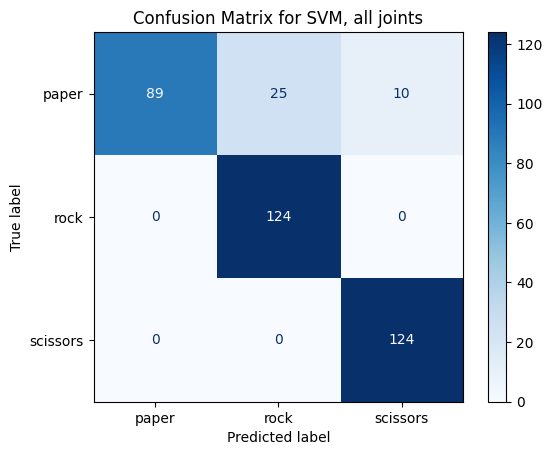

In [ ]:
# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(features, labels_array)

# svm_model.classes_ =["paper", "rock", "scissors"]

# Predict labels for the test set
y_pred = svm_model.predict(features_test)

# Evaluate the model
print_results(labels_test, y_pred, title="for SVM, all joints", include_negatives=False)

Accuracy: 0.6545226130653267
Classification Report for SVM, all joints, Base+kaggle:
              precision    recall  f1-score   support

       paper       0.97      0.57      0.72       252
        rock       0.50      0.95      0.66       265
    scissors       0.85      0.44      0.58       279

    accuracy                           0.65       796
   macro avg       0.78      0.66      0.65       796
weighted avg       0.77      0.65      0.65       796



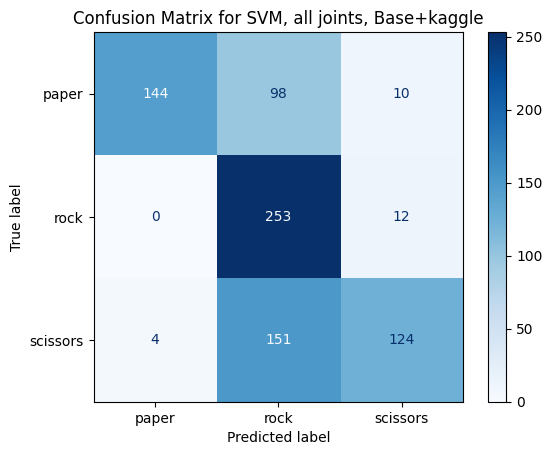

In [ ]:
# See how well it generalizes to kaggle
y_pred = svm_model.predict(features_kaggle)

# Evaluate the model
print_results(labels_kaggle, y_pred, title="for SVM, all joints, Base+kaggle", include_negatives=False)

## Using just distances between closest and furthest knuckle ("5-dist")

Fix: changed 4-dist --> 5-dist

In [ ]:
def calculate_distances(landmarks):
    wrist = landmarks[0]
    fingertips_indexes = [4, 8, 12, 16, 18]
    distances = [0] * len(fingertips_indexes)
    for i, idx in enumerate(fingertips_indexes):
        try:
            distances[i] = euclidean(wrist, landmarks[idx])
        except IndexError:
            # If the index is not found, leave the distance as 0
            pass
    return distances

In [ ]:
from itertools import chain

def build_5d(hf):
    ret = []
    for row in hf:
        landmarks = row['landmarks']
        if landmarks:
            distances = calculate_distances(landmarks)
            ret.append(distances)
        else:
            pass
    return ret

features_5d = build_5d(ds['train'])
features_5d_test = build_5d(ds['test'])

In [ ]:
features_5d_kaggle = build_5d(eval_ds)

Accuracy: 1.0
Classification Report for SVM (5 distances):
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



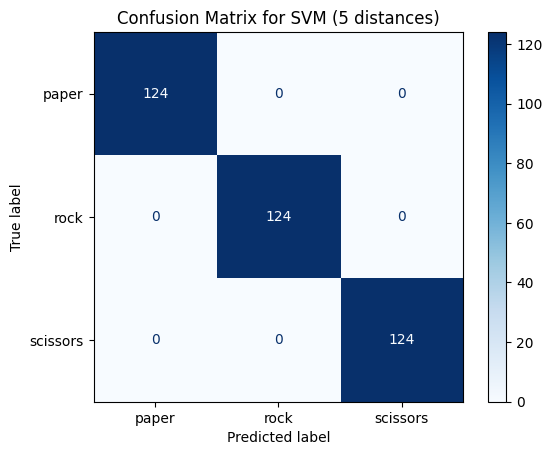

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(features_5d, labels_array)

# Predict labels for the test set
y_pred = svm_model.predict(features_5d_test)

print_results(labels_test, y_pred, title="for SVM (5 distances)", include_negatives=False)

Accuracy: 0.9987437185929648
Classification Report for SVM (5 distances), Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       252
        rock       1.00      1.00      1.00       265
    scissors       1.00      1.00      1.00       279

    accuracy                           1.00       796
   macro avg       1.00      1.00      1.00       796
weighted avg       1.00      1.00      1.00       796



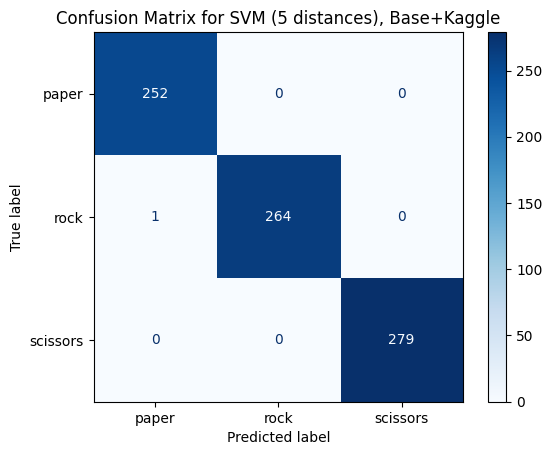

In [ ]:
# See how well it generalizes to kaggle
y_pred = svm_model.predict(features_5d_kaggle)

# Evaluate the model
print_results(labels_kaggle, y_pred, title="for SVM (5 distances), Base+Kaggle", include_negatives=False)

## 5-dist with variant: ignore z

Discussed in Paper on Table 6 as SVM (Joint) Base

In [ ]:
from itertools import chain


def build_5d_no_z(hf):
    ret = []
    for row in hf:
        landmarks = row['landmarks']
        if landmarks:
            remove_z = [(x, y) for (x, y, _) in landmarks]
            distances = calculate_distances(remove_z)
            ret.append(distances)
        else:
            pass
    return ret

features_5d_no_z = build_5d_no_z(ds['train'])
features_5d_no_z_test = build_5d_no_z(ds['test'])

In [ ]:
features_5d_no_z_kaggle = build_5d_no_z(eval_ds)

Accuracy: 1.0
Classification Report for SVM (5D), no z:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



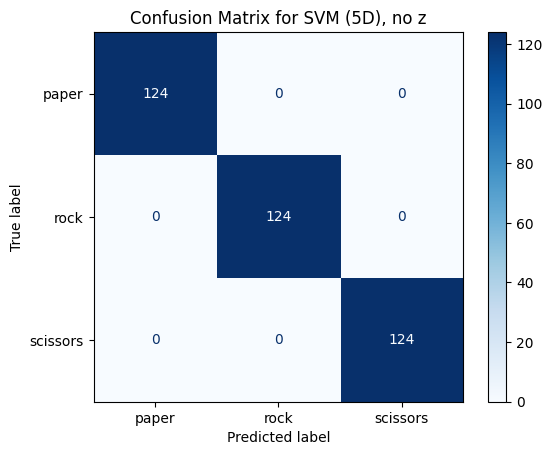

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(features_5d_no_z, labels_array)

# Predict labels for the test set
y_pred = svm_model.predict(features_5d_no_z_test)
print_results(labels_test, y_pred, title="for SVM (5D), no z", include_negatives=False)

Accuracy: 0.9974874371859297
Classification Report for SVM (5D), no z, Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      0.99      1.00       252
        rock       0.99      1.00      1.00       265
    scissors       1.00      1.00      1.00       279

    accuracy                           1.00       796
   macro avg       1.00      1.00      1.00       796
weighted avg       1.00      1.00      1.00       796



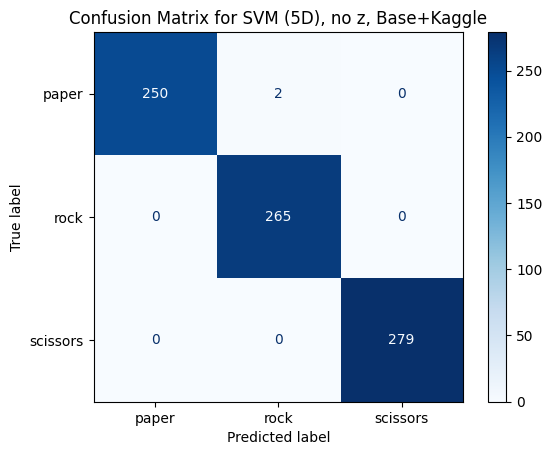

In [ ]:
y_pred = svm_model.predict(features_5d_no_z_kaggle)
print_results(labels_kaggle, y_pred, title="for SVM (5D), no z, Base+Kaggle", include_negatives=False)

Accuracy: 1.0
Classification Report for SVM (5D, no z, linear):
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



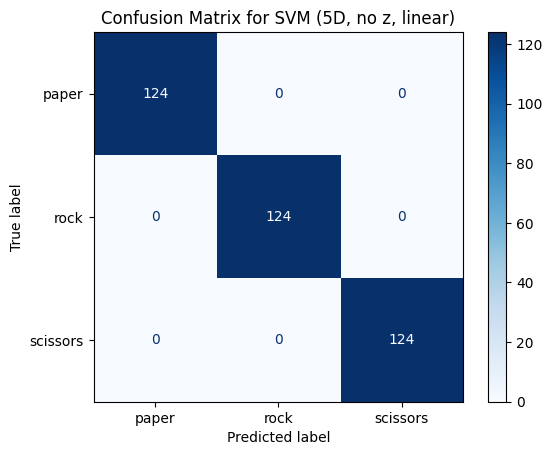

In [ ]:
# Initialize and train an SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(features_5d_no_z, labels_array)

# Predict labels for the test set
y_pred = svm_model.predict(features_5d_no_z_test)
print_results(labels_test, y_pred, title="for SVM (5D, no z, linear)")

Accuracy: 1.0
Classification Report for SVM (5D, no z, linear) Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       252
        rock       1.00      1.00      1.00       265
    scissors       1.00      1.00      1.00       279

    accuracy                           1.00       796
   macro avg       1.00      1.00      1.00       796
weighted avg       1.00      1.00      1.00       796



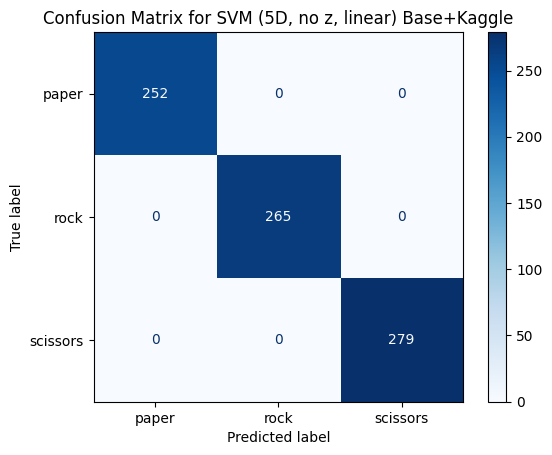

In [ ]:
# Predict labels for the test set
y_pred = svm_model.predict(features_5d_no_z_kaggle)
print_results(labels_kaggle, y_pred, title="for SVM (5D, no z, linear) Base+Kaggle")

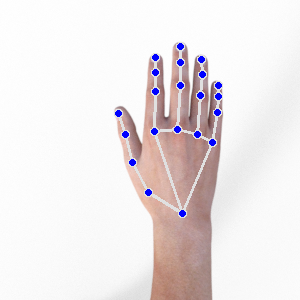

In [ ]:
ds['test'][83]['annotated']

## 9-dist

Motivation: to solve the demo not working when the hand is close to the camera, try to also measure distances to the closest knuckle instead of only looking at the furthest knuckle

In [ ]:
def calculate_9d(landmarks):
    wrist = landmarks[0]
    fingertips_indexes = [4, 8, 12, 16, 20, 5, 9, 13, 17]
    distances = [euclidean(wrist, landmarks[i]) for i in fingertips_indexes]
    return distances

In [ ]:
from itertools import chain

def build_9d(hf):
    ret = np.empty((len(hf), 9))
    for i, row in enumerate(hf):
        landmarks = row['landmarks']
        if landmarks:
            distances = calculate_9d(landmarks)
            ret[i] = distances
        else:
            pass
    return ret
features_9d = build_9d(ds['train'])
features_9d_test = build_9d(ds['test'])
features_9d_kaggle = build_9d(eval_ds)

In [ ]:
features_9d.shape, features_9d_test.shape

((2520, 9), (372, 9))

Accuracy: 1.0
Classification Report for SVM (9 distances):
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



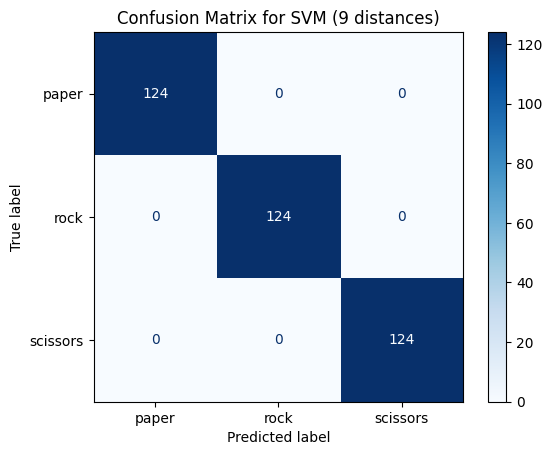

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# Initialize and train an SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(features_9d, labels_array)

# Predict labels for the test set
y_pred = svm_model.predict(features_9d_test)
print_results(labels_test, y_pred, title="for SVM (9 distances)")

Accuracy: 1.0
Classification Report for SVM (9 distances), Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       252
        rock       1.00      1.00      1.00       265
    scissors       1.00      1.00      1.00       279

    accuracy                           1.00       796
   macro avg       1.00      1.00      1.00       796
weighted avg       1.00      1.00      1.00       796



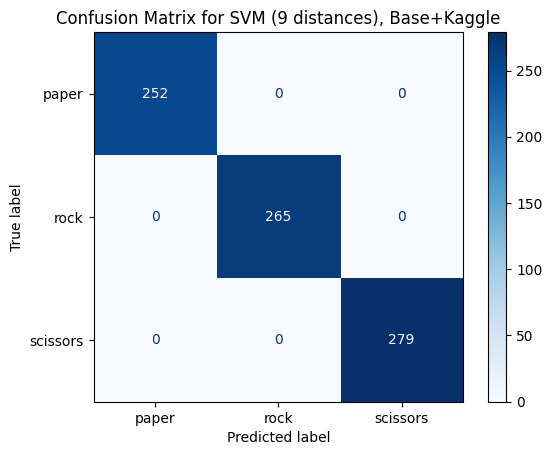

In [ ]:

y_pred = svm_model.predict(features_9d_kaggle)
print_results(labels_kaggle, y_pred, title="for SVM (9 distances), Base+Kaggle")

save model

In [ ]:
import pickle
with open("svm_9d.pkl", 'wb') as f:
    pickle.dump(svm_model, f)

## How to run SVM without retraining

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1-8hm-quWlYfQeXkMeR_lhkMxqV-d-Nkq/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=1-8hm-quWlYfQeXkMeR_lhkMxqV-d-Nkq
To: /content/svm.pkl
100% 24.4k/24.4k [00:00<00:00, 6.77MB/s]


In [ ]:
with open("svm.pkl", 'wb') as f:
    svm_model = pickle.load(f)


# NN

In [ ]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_features=5, hidden_layers=64, dropout=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden_layers)  # Input layer
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_layers, 3)  # Output layer

        self.dropout = dropout

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for the input layer
        if self.dropout:
            x = self.drop1(x)
        x = torch.relu(self.fc2(x))  # No activation function for the output layer
        if self.dropout:
            x = self.drop2(x)
        x = self.fc3(x)
        return x

In [ ]:
# TODO: this is not GPU optimized

def joint_train_nn(net, X_train_np, X_test_np, epochs=25, title="for NN", do_random_scaling=False):

    start = time.time()

    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    X_val = torch.tensor(X_test_np[:50], dtype=torch.float32)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_train = base_ds['train']['label']
    y_val = base_ds['test'][:50]['label']
    y_test = base_ds['test']['label']

    # Create Dataset and Dataloader
    dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.uint8))
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Define a loss function and an optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())

    progress = [] # keep track of training and val loss/acc

    # Training loop
    for epoch in tqdm(range(epochs)):  # number of epochs
        train_correct = 0
        train_total = 0
        for inputs, targets in dataloader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Data augmentation: random scaling (robustness for distance)
            if do_random_scaling:
                scaling_factor = 0.75 * torch.rand(inputs.size(0), 1) + 0.25
                inputs = inputs * scaling_factor

            # Forward pass
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += len(targets)

        # Print loss for every epoch
        # print(f"Epoch {epoch+1}, Loss: {loss.item()}")

        # quick validation
        with torch.no_grad():
            _, val_pred = torch.max(net(X_val), 1)
            val_acc = accuracy_score(y_val, val_pred)
        progress.append((loss.item(), train_correct / train_total, val_acc))

    # train_test_split(transformed_data_base_set, ds_shuffled['train']['label'], test_size=0.2, random_state=42)

    # # Create and train the SVM classifier
    with torch.no_grad():
        _, y_pred = torch.max(net(X_test), 1)

    end = time.time()
    print(f"Time: {end - start}")
    # # Evaluate the classifier
    print_results(y_test, y_pred, title=title)

    # pca_for_plotting = PCA(n_components=2)
    # X_train_2d = pca_for_plotting.fit_transform(X_train)

    # plt.figure(figsize=(10, 7))
    # scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, alpha=0.5)
    # plt.title("SVM Classification (2D Projection)")
    # plt.legend(*scatter.legend_elements(), title="Classes")
    # plt.show()

    return net, progress

In [ ]:
def eval_nn(net, X_test_np, y_test, title="for NN"):
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    # y_test = base_ds['test']['label']

    with torch.no_grad():
        _, y_pred = torch.max(net(X_test), 1)

    # # Evaluate the classifier
    print_results(y_test, y_pred, title=title)

In [ ]:
def plot_progress(progress, title="for NN"):
    df = pd.DataFrame(progress, columns=['loss','train','val'])
    ax = sns.lineplot(df)
    ax.set_title(f"Accuracy and Loss {title}")
    ax.set(xlabel='Epoch', ylabel='Accuracy or Cross Entropy Loss')
    plt.show()

## NN 5 dist

Discussed in paper in table 6 as NN (Joint) Base

100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


Time: 11.838079690933228
Accuracy: 1.0
Classification Report for NN, 5 distances:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



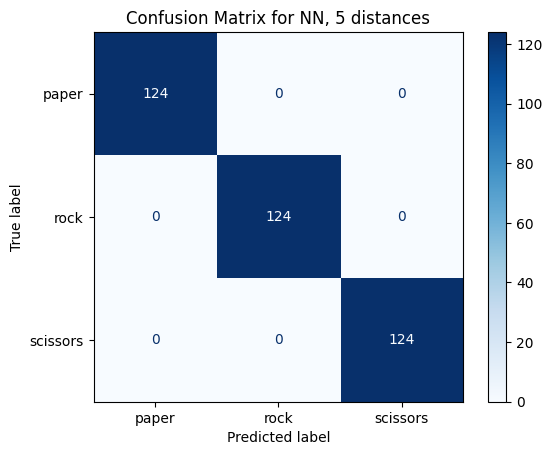

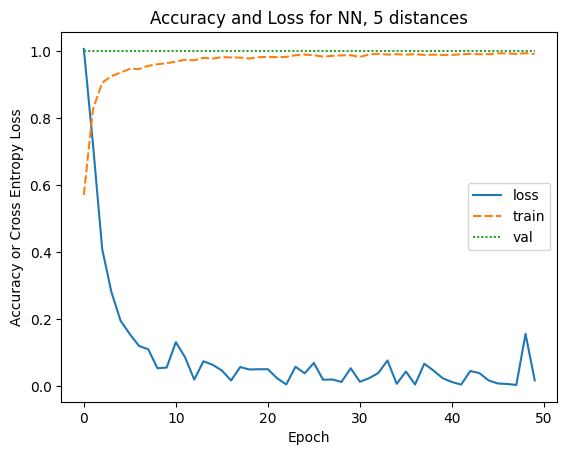

In [ ]:
# Create an instance of the network
net = Net(input_features=5, hidden_layers=64)
title="for NN, 5 distances"
_, progress = joint_train_nn(net, features_5d, features_5d_test, epochs=50, title=title)
plot_progress(progress, title=title)

Accuracy: 1.0
Classification Report for 5 distances, Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       252
        rock       1.00      1.00      1.00       265
    scissors       1.00      1.00      1.00       279

    accuracy                           1.00       796
   macro avg       1.00      1.00      1.00       796
weighted avg       1.00      1.00      1.00       796



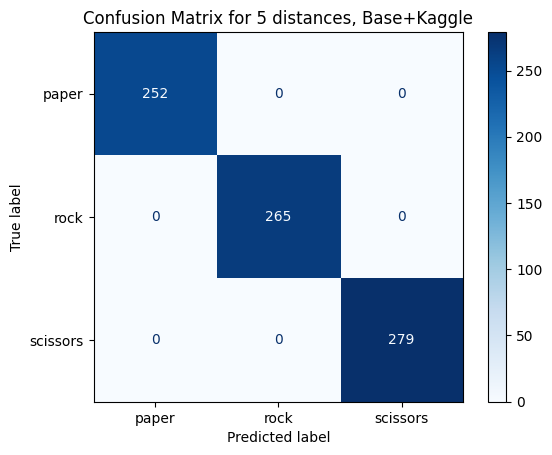

In [ ]:
eval_nn(net, features_5d_kaggle, labels_kaggle, title="for 5 distances, Base+Kaggle")

100%|██████████| 25/25 [00:04<00:00,  5.43it/s]


Time: 5.093157768249512
Accuracy: 1.0
Classification Report for NN, 9 distances:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



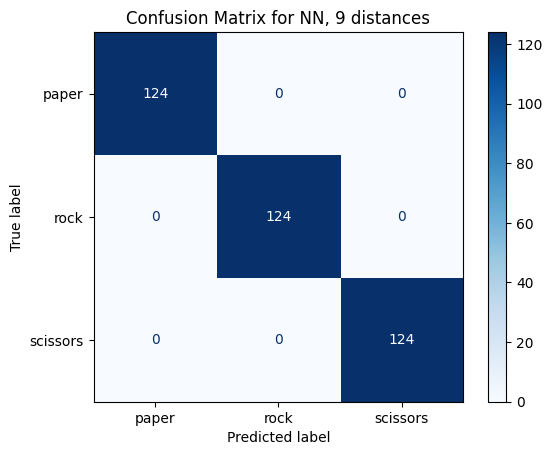

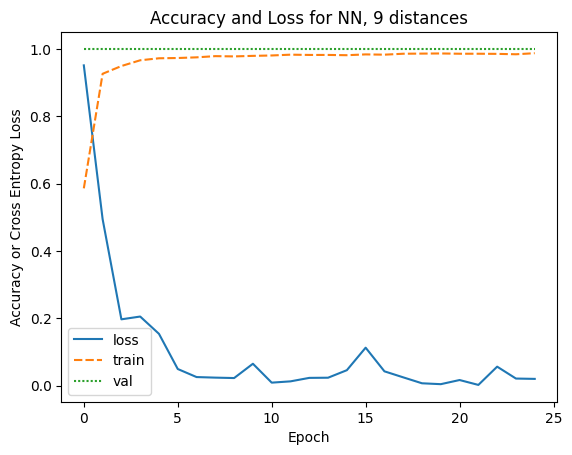

In [ ]:
# Create an instance of the network
net = Net(input_features=9, hidden_layers=64)
title="for NN, 9 distances"
_, progress = joint_train_nn(net, features_9d, features_9d_test, epochs=25, title=title)
plot_progress(progress, title=title)

Accuracy: 1.0
Classification Report for 9 distances, Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       252
        rock       1.00      1.00      1.00       265
    scissors       1.00      1.00      1.00       279

    accuracy                           1.00       796
   macro avg       1.00      1.00      1.00       796
weighted avg       1.00      1.00      1.00       796



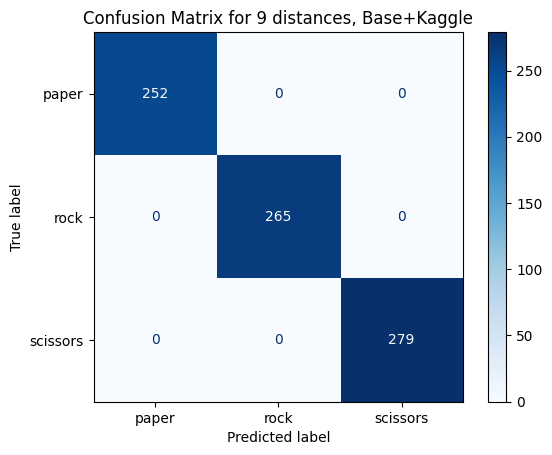

In [ ]:
eval_nn(net, features_9d_kaggle, labels_kaggle, title="for 9 distances, Base+Kaggle")

In [ ]:
torch.save(net.state_dict(), 'net_9d.pt')

## 9D, random scaling

Idea: implement random scaling of the distances as a data augmentation step. This is akin to the distances decreasing as the hands get further away from the camera. It seems to empirically increase robustness in the demo.

100%|██████████| 25/25 [00:06<00:00,  3.61it/s]


Time: 7.755736351013184
Accuracy: 1.0
Classification Report for NN (9D, random scaling):
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



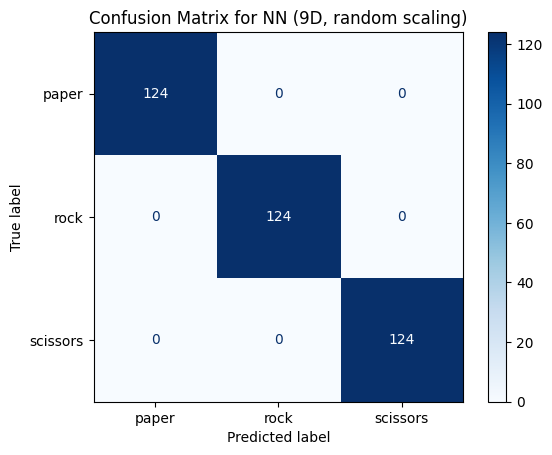

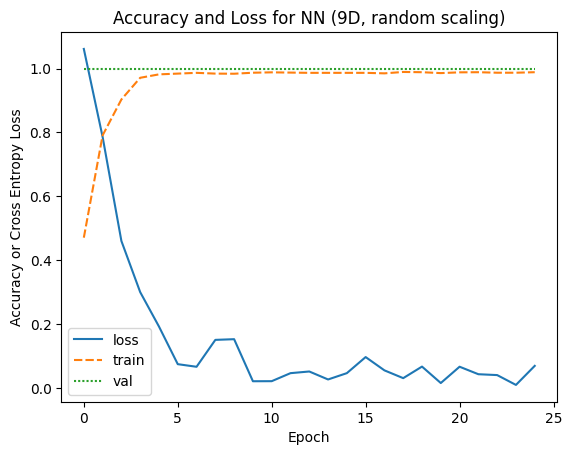

In [ ]:
# Try 9D, random scaling
net = Net(input_features=9, hidden_layers=64)
title = "for NN (9D, random scaling)"
_, progress = joint_train_nn(net, features_9d, features_9d_test, epochs=25, do_random_scaling=True, title=title)
plot_progress(progress, title=title)

Accuracy: 1.0
Classification Report for NN (9D, random scaling) Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       252
        rock       1.00      1.00      1.00       265
    scissors       1.00      1.00      1.00       279

    accuracy                           1.00       796
   macro avg       1.00      1.00      1.00       796
weighted avg       1.00      1.00      1.00       796



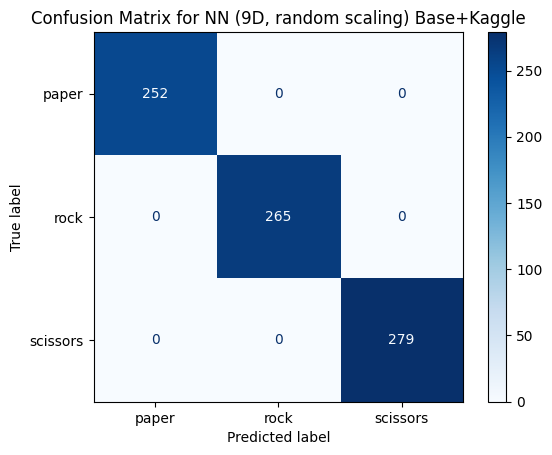

In [ ]:
eval_nn(net, features_9d_kaggle, labels_kaggle, title="for NN (9D, random scaling) Base+Kaggle")

In [ ]:
torch.save(net.state_dict(), 'net_9d_scaling.pt')

## Finally, go back to training a NN on all joints

100%|██████████| 150/150 [00:31<00:00,  4.71it/s]


Time: 32.905184507369995
Accuracy: 0.8897849462365591
Classification Report for NN (all joints):
              precision    recall  f1-score   support

       paper       1.00      0.67      0.80       124
        rock       0.89      1.00      0.94       124
    scissors       0.83      1.00      0.91       124

    accuracy                           0.89       372
   macro avg       0.91      0.89      0.88       372
weighted avg       0.91      0.89      0.88       372



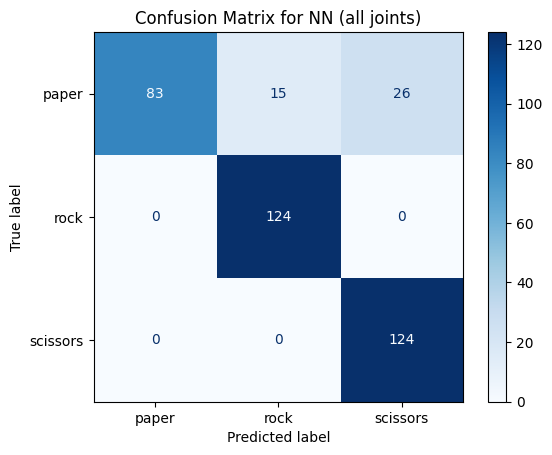

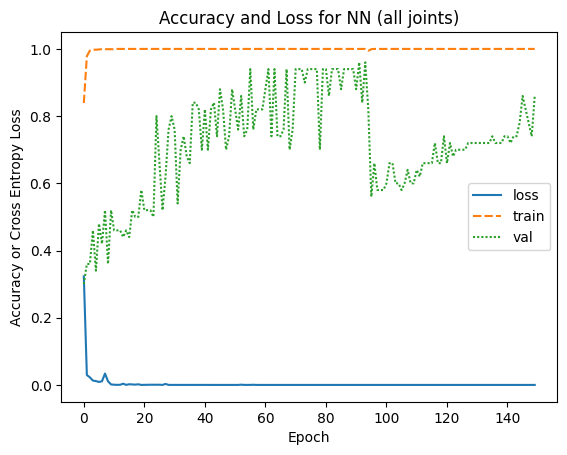

In [ ]:
# Try 9D, random scaling
# 63 = 21 * 3
net = Net(input_features=63, hidden_layers=96, dropout=False)
title = "for NN (all joints)"
_, progress = joint_train_nn(net, features, features_test, epochs=150, title=title)
plot_progress(progress, title=title)

100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Time: 36.738317251205444
Accuracy: 0.9220430107526881
Classification Report for NN (all joints):
              precision    recall  f1-score   support

       paper       1.00      0.77      0.87       124
        rock       0.91      1.00      0.95       124
    scissors       0.89      1.00      0.94       124

    accuracy                           0.92       372
   macro avg       0.93      0.92      0.92       372
weighted avg       0.93      0.92      0.92       372



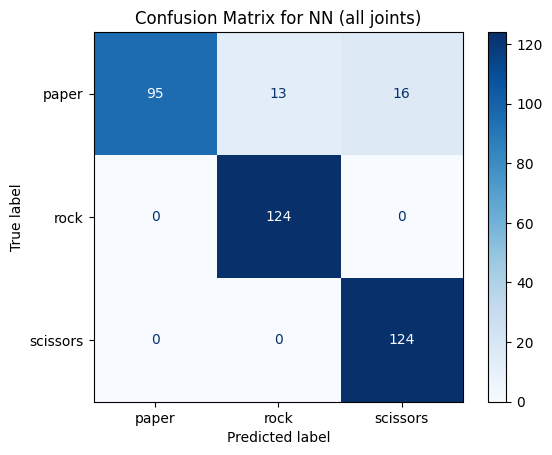

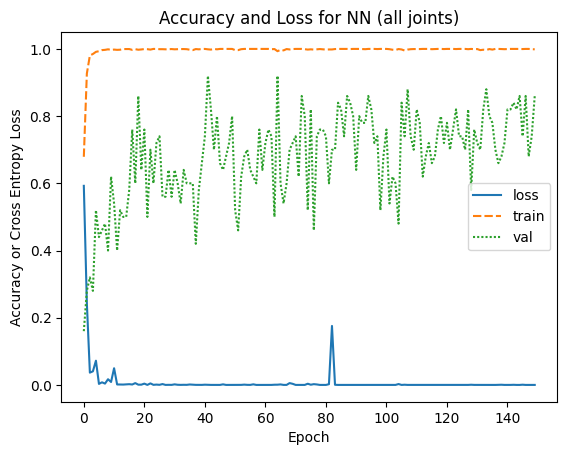

In [ ]:
# Try all joints
# 63 = 21 * 3
net = Net(input_features=63, hidden_layers=128, dropout=True)
title = "for NN (all joints)"
_, progress = joint_train_nn(net, features, features_test, epochs=150, title=title)
plot_progress(progress, title=title)

Accuracy: 0.6633165829145728
Classification Report for NN (all joints) Base+Kaggle:
              precision    recall  f1-score   support

       paper       0.87      0.60      0.71       252
        rock       0.54      0.95      0.69       265
    scissors       0.79      0.44      0.57       279

    accuracy                           0.66       796
   macro avg       0.74      0.67      0.66       796
weighted avg       0.74      0.66      0.65       796



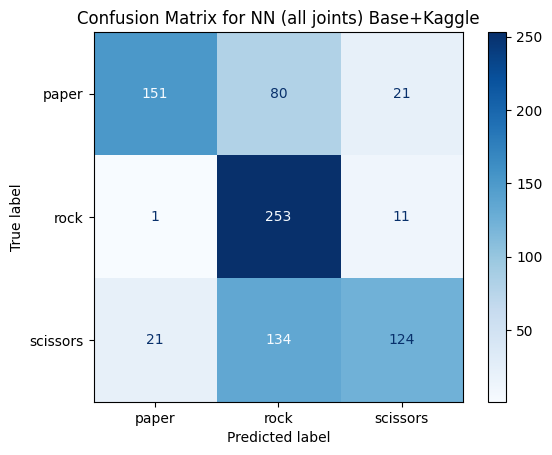

In [ ]:
eval_nn(net, features_kaggle, labels_kaggle, title="for NN (all joints) Base+Kaggle")

100%|██████████| 150/150 [00:54<00:00,  2.76it/s]


Time: 55.26449012756348
Accuracy: 0.8306451612903226
Classification Report for NN (all joints):
              precision    recall  f1-score   support

       paper       1.00      0.51      0.67       124
        rock       0.72      1.00      0.84       124
    scissors       0.90      0.98      0.94       124

    accuracy                           0.83       372
   macro avg       0.87      0.83      0.82       372
weighted avg       0.87      0.83      0.82       372



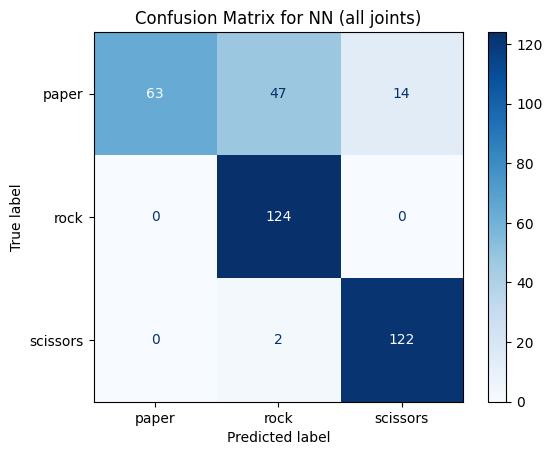

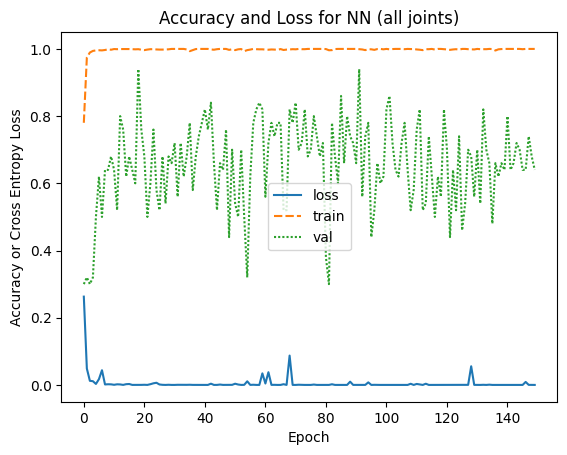

In [ ]:
net = Net(input_features=63, hidden_layers=256, dropout=True)
title = "for NN (all joints)"
_, progress = joint_train_nn(net, features, features_test, epochs=150, title=title)
plot_progress(progress, title=title)

100%|██████████| 300/300 [01:08<00:00,  4.40it/s]


Time: 68.62744235992432
Accuracy: 0.8413978494623656
Classification Report for NN (all joints):
              precision    recall  f1-score   support

       paper       1.00      0.53      0.69       124
        rock       0.88      0.99      0.93       124
    scissors       0.75      1.00      0.86       124

    accuracy                           0.84       372
   macro avg       0.88      0.84      0.83       372
weighted avg       0.88      0.84      0.83       372



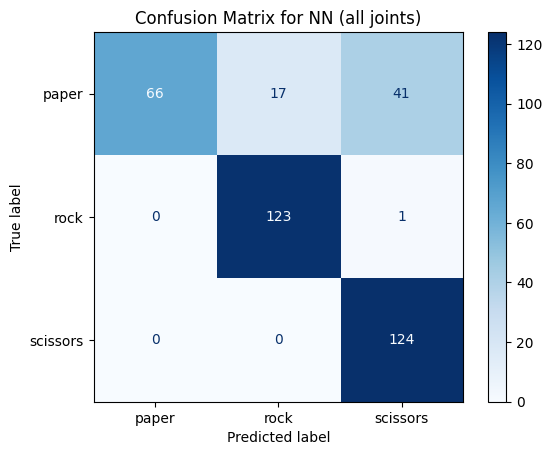

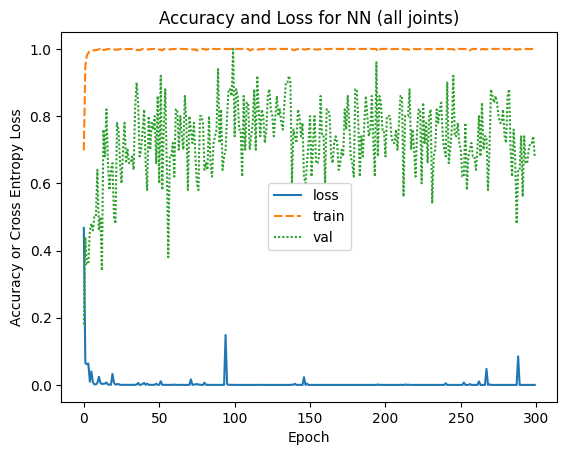

In [ ]:
# Try all joints, keep going. looks like loss keeps decreasing
net = Net(input_features=63, hidden_layers=128, dropout=True)
title = "for NN (all joints)"
_, progress = joint_train_nn(net, features, features_test, epochs=300, title=title)
plot_progress(progress, title=title)

In [ ]:
features.shape

(2520, 63)

In [ ]:
features

array([[ 5.65708220e-01,  7.02788234e-01,  1.14920738e-06, ...,
         7.19482541e-01,  1.79504275e-01, -1.71779454e-01],
       [ 5.63125134e-01,  7.08851814e-01,  9.58410510e-07, ...,
         7.13824868e-01,  1.78486168e-01, -1.58144414e-01],
       [ 5.58468401e-01,  7.10649967e-01,  9.65958748e-07, ...,
         7.07000554e-01,  1.68523401e-01, -1.73898950e-01],
       ...,
       [ 5.39984822e-01,  6.79222226e-01,  8.42739780e-07, ...,
         5.71111262e-01,  4.52065229e-01,  4.50485609e-02],
       [ 5.43254137e-01,  6.77174330e-01,  8.15775707e-07, ...,
         5.72915852e-01,  4.48954016e-01,  7.63297305e-02],
       [ 5.41941583e-01,  6.79242134e-01,  8.51073821e-07, ...,
         5.71838737e-01,  4.51175541e-01,  5.01875170e-02]])

In [ ]:
# remove every 3rd index
# num_examples = features.shape[0]
features_no_z = features.reshape(-1,3)[:,:2] # (52920, 2)
features_no_z = features_no_z.reshape(-1,2 * 21)

features_no_z_test = features_test.reshape(-1,3)[:,:2].reshape(-1,2 * 21)

In [ ]:
features_no_z_kaggle = features_kaggle.reshape(-1,3)[:,:2].reshape(-1,2 * 21)

100%|██████████| 25/25 [00:05<00:00,  4.92it/s]


Time: 5.8403308391571045
Accuracy: 1.0
Classification Report for NN (all joints, no z):
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       124
        rock       1.00      1.00      1.00       124
    scissors       1.00      1.00      1.00       124

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



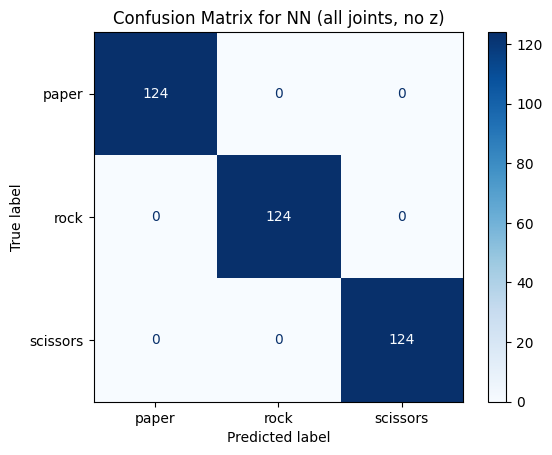

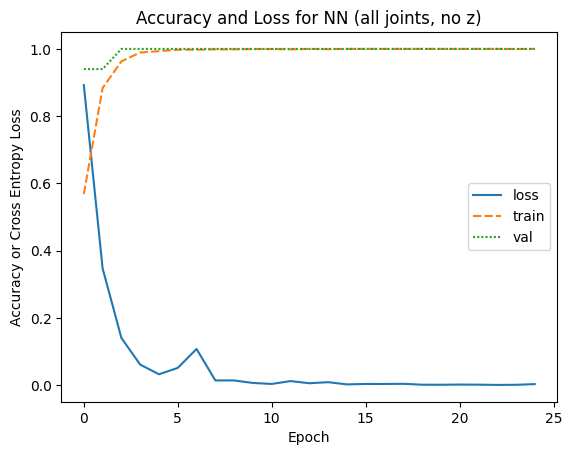

In [ ]:
# Try 9D, keep going. looks like loss keeps decreasing
net = Net(input_features=42, hidden_layers=64, dropout=False)
title = "for NN (all joints, no z)"
_, progress = joint_train_nn(net, features_no_z, features_no_z_test, epochs=25, title=title)
plot_progress(progress, title=title)

Accuracy: 0.6507537688442211
Classification Report for NN (all joints, no z) Base+Kaggle:
              precision    recall  f1-score   support

       paper       1.00      0.52      0.68       252
        rock       0.49      1.00      0.66       265
    scissors       0.97      0.44      0.61       279

    accuracy                           0.65       796
   macro avg       0.82      0.65      0.65       796
weighted avg       0.82      0.65      0.65       796



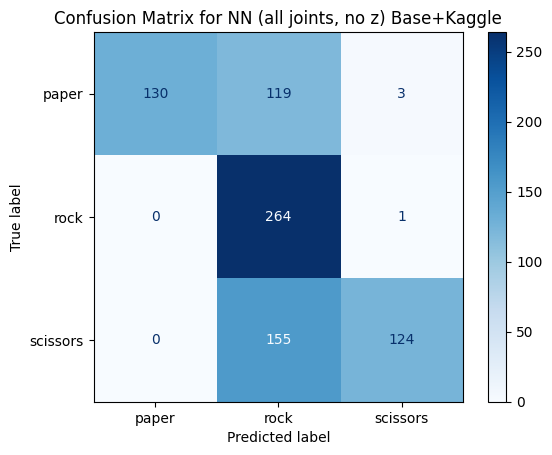

In [ ]:
eval_nn(net, features_no_z_kaggle, labels_kaggle, title="for NN (all joints, no z) Base+Kaggle")

View erroneous

In [ ]:
with torch.no_grad():
    _, _y_pred = torch.max(net(torch.tensor(features_9d_test, dtype=torch.float32)), 1)
np.where(_y_pred.numpy() != base_ds['test']['label'])

(array([], dtype=int64),)

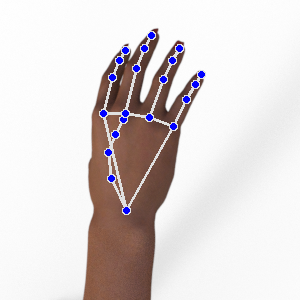

In [ ]:
base_ds['test'][59]['annotated']